[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dm4bem-2023/project-thb-beauquis/HEAD)


# Projet thermique du bâtiment:
# Bilan thermique d'un local cubique

Nous nous proposons d'étudier un local cubique, dont quatre des faces sont composées de béton et d'une coiche d'isolant, ces faces sont exposées au rayonnement solaire. La face inférieure est en contact avec le sol, elle est également composée de béton et d'isolant. La dernière face est complètement vitrée. 

Pour se lancer dans notre étude, nous nous proposons de faire quelques hypothèses simplificatrices:
- sol recevant uniquement un rayonnement IR correspondant à l'échuffement du sol 
- on ne discrétise pas l'épaisseur de la vitre puisque la variation de lambda n'est pas significative au vu de l'épaisseur de la vitre 
- on considère uniquement un rayonnement solaire reçu en CLO
- les rayonnements entre les faces du cube sont également considérés en GLO uniquement


## I - Modélisation des différentes faces

Afin d'obtenir le modèle le plus précis possible, on décide de discrétiser nos murs de béton en les divisant en couches de béton et 2 couches d'isolant. Cela nous permet de gagner en précision afin de modéliser l'évolution de la température au sein du mur. 

Nous pouvons donc modéliser le mur par un circuit électrique équivalent, dans lequel chaque noeud correspond à une température, plus précisément à la température au milieu de chaque couche. 
On distinque plusieurs éléments:
- les résistances modélisant le phénomène de **conduction** au sein du mur : 

$$R_{cd} = \dfrac{e}{\lambda S}$$

- les résistances modélisant le phénomène de **convection** à la frontière entre le mur et l'extérieur:

$$R_{cv} = \dfrac{1}{h S}$$

- les résistances représentant les **échanges radiatifs** de chaleur entre deux faces de notre cube (1 et 2):

$$ R = R_a + R_b + R_c$$

$$ {R_a}^{-1} = 4 \sigma \cdot {\bar{\theta}}^3 \cdot \dfrac{\epsilon_1}{1-\epsilon_1} \cdot S_1  \qquad
{R_b}^{-1} = 4 \sigma \cdot {\bar{\theta}}^3 \cdot F_{1-2} \cdot S_1 \qquad
{R_c}^{-1} = 4 \sigma \cdot {\bar{\theta}}^3 \cdot \dfrac{\epsilon_2}{1-\epsilon_2} \cdot S_2    $$

- les condensateurs, qui modélisent le pouvoir qu'à le mur à **stocker la chaleur**: 

$$ C = \rho \cdot c \cdot V $$

- les sources de tension permettant de fixer l'extérieur du mur à la **température extérieure** <br> <br>

- les sources de courant permettant de modéliser l'apport d'un flux, ici le flux lié au **rayonnement solaire**:

$$ \Phi = \alpha \cdot S \cdot E$$

On peut modéliser chaque face de notre cube grâce à ces éléments. 

### Nomenclature

- **e** : épaisseur ($m$)
- **$\lambda$** : conductivité ($W/m.K$)
- **S** : surface ($m^2$)
- **h** : coefficient convectif ($W/m^2 \cdot K$)
- **$\theta$** : température ($K$)
- **$F_{1-2}$** : facteur de forme entre les faces 1 et 2 ($\emptyset$)
- **$\epsilon$** : emissivité ($\emptyset$)
- **$\sigma$** : Constante de Boltzmann ($5.67 \cdot 10^{-8}  W/m^2 \cdot K^4$)
- **$\rho$** : masse volumique ($kg/m^3$)
- **c** : capacité calorifique massique ($J/kg \cdot K$)

![Discrétisation mur](02_RC_model.svg)


<td style="background-color:lightblue">


# Code: Matrice A

In [6]:
#définition des variables

hc_ext = 2+4*2 #W/m^2.K
hc_int = 4 #W/m^2.K
S_paroi = 3*3 #m^2
T_ext = 11+273.15 #K
T_sol = 5+273.15 #K

λ_beton = 2 #W/m.K
e_beton = 0.2 #m
V_beton = S_paroi * e_beton
rho_c_beton = 2.5e6 #J/K.m^3

λ_isolant = 0.04 #W/m.K
e_isolant = 0.08 #m
V_isolant = S_paroi * e_isolant
rho_c_isolant = 2.0e4 #J/K.m^3

λ_vitre = 1.2 #W/m.K
e_vitre = 5e-3 #m

α_GLO = 0.9
α_CLO = 0.8

E_diffus = 100 #W/m^2
E_horizontal = 300 #W/m^2
P_chauffage = 1000 #W

ɛ_i = 0.92 
ɛ_v = 0.89

σ = 5.67e-8 #W/m^2.K^4

Q_vex = 30 #m^3/h
rho_air = 1.225 #kg/m^3
c_air = 1000 #J/K.kg


In [7]:
import numpy as np
import itertools as it

np.set_printoptions(threshold=np.inf)

A = np.zeros((64,43))
central = []

#Faces béton-isolant

for j in range (0,5):
    j1 = j*9
    j2 = j*8
    A[j1,j2] = 1
    for i in range (1,8):
        A[j1+i,j2+i] = 1
        A[j1+i,j2+i-1] = -1
    A[j1+8,j2+7] = -1
    A[j1+8,42] = 1
    central.append(j2+7)
    
# Face vitrée 

A[45,40] = 1
A[46,40] = -1
A[46,41] = 1 
A[47,41] = -1
A[47,42] = 1
central.append(41)
central_com = list(it.combinations(central,2))
A[63,42] = 1
#Echanges radiatifs

for i in range (0,15):
    A[48+i,central_com[i][0]] = -1
    A[48+i,central_com[i][1]] = 1
        

<td style="background-color:lightblue">


# Code: Matrice G

In [8]:
R = []
G = np.zeros((64,64))

R_A1 = 1/(hc_ext*S_paroi)
R_A2 = e_beton/(8*λ_beton*S_paroi)
R_A3 = e_beton/(4*λ_beton*S_paroi)
R_A4 = e_beton/(4*λ_beton*S_paroi)
R_A5 = e_beton/(4*λ_beton*S_paroi)
R_A6 = e_isolant/(4*λ_isolant*S_paroi)+e_beton/(8*λ_beton*S_paroi)
R_A7 = e_isolant/(2*λ_isolant*S_paroi)
R_A8 = e_isolant/(4*λ_isolant*S_paroi)
R_A9 = 1/(hc_int*S_paroi)

for i in range (5):
    R.append(R_A1)
    R.append(R_A2)
    R.append(R_A3)
    R.append(R_A4)
    R.append(R_A5)
    R.append(R_A6)
    R.append(R_A7)
    R.append(R_A8)
    R.append(R_A9)


R_V2 = e_vitre/(λ_vitre*S_paroi)

R.append(R_A1)
R.append(R_V2)
R.append(R_A9)

R_VMC = (1-0.9)*Q_vex*rho_air*c_air/60

for i in range(15):
    R.append(1)

for i in range (len(R)):
    G[i,i] = R[i]**(-1)
    

<td style="background-color:lightblue">


# Code Matrice C

In [9]:
C_beton = S_paroi*e_beton*rho_c_beton
C_isolant = S_paroi*e_isolant*rho_c_isolant

C_liste = []

for i in range(5):
    C_liste.append(0)
    for j in range (4):
        C_liste.append(C_beton/4)
    for j in range (2):
        C_liste.append(C_isolant/2)
    C_liste.append(0)
    
for i in range(3):
    C_liste.append(0)
    
C = np.zeros((43,43))

for i in range (len(C_liste)):
    C[i,i] = C_liste[i]
    

<td style="background-color:lightblue">


# Code: Matrice B

In [10]:
B = np.zeros(64)

for i in range(4):
    B[9*i] = T_ext 
    
B[36] = T_sol

B[45] = T_ext

B[63] = T_ext

<td style="background-color:lightblue">


# Code: Matrice f

In [11]:
f_1 = α_GLO*E_diffus*S_paroi
f_2 = α_GLO*E_diffus*S_paroi
f_3 = α_GLO*E_diffus*S_paroi
f_4 = α_GLO*E_diffus*S_paroi
f_5 = 600
f_6 = α_CLO*E_horizontal*S_paroi
f_7 = P_chauffage

f = np.zeros(43)

f[0] = f_1
f[8] = f_2
f[16] = f_3
f[24] = f_4
f[32] = f_5
f[40] = f_6
f[42] = f_7

print(f)

[ 810.    0.    0.    0.    0.    0.    0.    0.  810.    0.    0.    0.
    0.    0.    0.    0.  810.    0.    0.    0.    0.    0.    0.    0.
  810.    0.    0.    0.    0.    0.    0.    0.  600.    0.    0.    0.
    0.    0.    0.    0. 2160.    0. 1000.]


<td style="background-color:lightblue">


# Calcul de la température aux différents points

In [12]:
θ = np.linalg.inv((np.transpose(A)@G@A))@(np.transpose(A)@G@B+f)

θ_deg = θ-273.15
print(θ_deg)

[21.23009653 21.3838586  21.69138273 21.99890686 22.306431   28.61067572
 40.91164103 47.06212368 21.23009653 21.3838586  21.69138273 21.99890686
 22.306431   28.61067572 40.91164103 47.06212368 21.23009653 21.3838586
 21.69138273 21.99890686 22.306431   28.61067572 40.91164103 47.06212368
 21.23009653 21.3838586  21.69138273 21.99890686 22.306431   28.61067572
 40.91164103 47.06212368 13.24193085 13.43883887 13.83265492 14.22647097
 14.62028701 22.69351595 38.44615779 46.32247871 39.6154608  39.80777167
 50.35942048]


In [13]:
print(central_com)

[(7, 15), (7, 23), (7, 31), (7, 39), (7, 41), (15, 23), (15, 31), (15, 39), (15, 41), (23, 31), (23, 39), (23, 41), (31, 39), (31, 41), (39, 41)]


[20.9629027  21.08326553 21.32399121 21.56471688 21.80544256 26.74031888
 36.36934586 41.18385935 20.9629027  21.08326553 21.32399121 21.56471688
 21.80544256 26.74031888 36.36934586 41.18385935 20.9629027  21.08326553
 21.32399121 21.56471688 21.80544256 26.74031888 36.36934586 41.18385935
 20.9629027  21.08326553 21.32399121 21.56471688 21.80544256 26.74031888
 36.36934586 41.18385935 13.00829022 13.17599317 13.51139906 13.84680495
 14.18221084 21.05803157 34.47426716 41.18238495 40.91787676 41.16445496
 45.81000918]


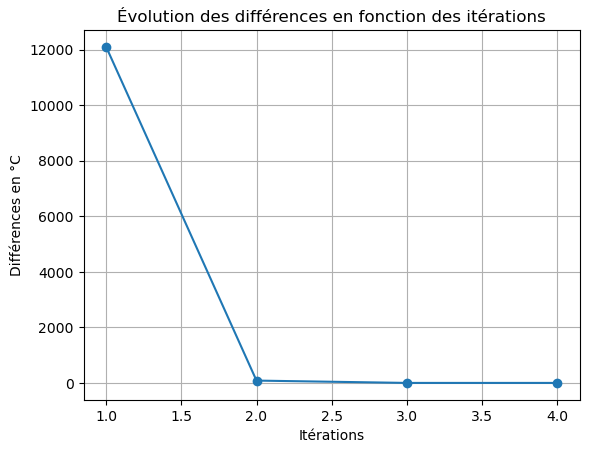

In [14]:
detail = {7:ɛ_i,15:ɛ_i,23:ɛ_i,31:ɛ_i,39:ɛ_i,41:ɛ_v}



tol = 0.0001

dif = 1

θ = np.ones(43)*20

it = 1

liste_dif = []
compteur = []

while dif > tol :
    
    dif = 0
    
    R_ray = []
    for a,b in central_com:
        R_ray.append((1-detail[a])/(detail[a]*4*σ*((θ[a]+θ[b])/2)**4*S_paroi)+(1/(4*σ*((θ[a]+θ[b])/2)**4*S_paroi*0.2))+(1-detail[b])/(detail[b]*4*σ*((θ[a]+θ[b])/2)**4*S_paroi))
    for i in range (len(R_ray)):
        G[48+i,48+i] = R_ray[i]**(-1)
    θ_prev = θ
    θ = np.linalg.inv((np.transpose(A)@G@A))@(np.transpose(A)@G@B+f)
    
    for i in range(len(θ)):
        dif += abs(θ[i]-θ_prev[i])
    liste_dif.append(dif)
    compteur.append(it)
    it += 1

print(θ-273.15)

import matplotlib.pyplot as plt


# Tracer le graphique
plt.plot(compteur, liste_dif, marker='o', linestyle='-')
plt.title("Évolution des différences en fonction des itérations")
plt.xlabel("Itérations")
plt.ylabel("Différences en °C")
plt.grid(True)
plt.show()



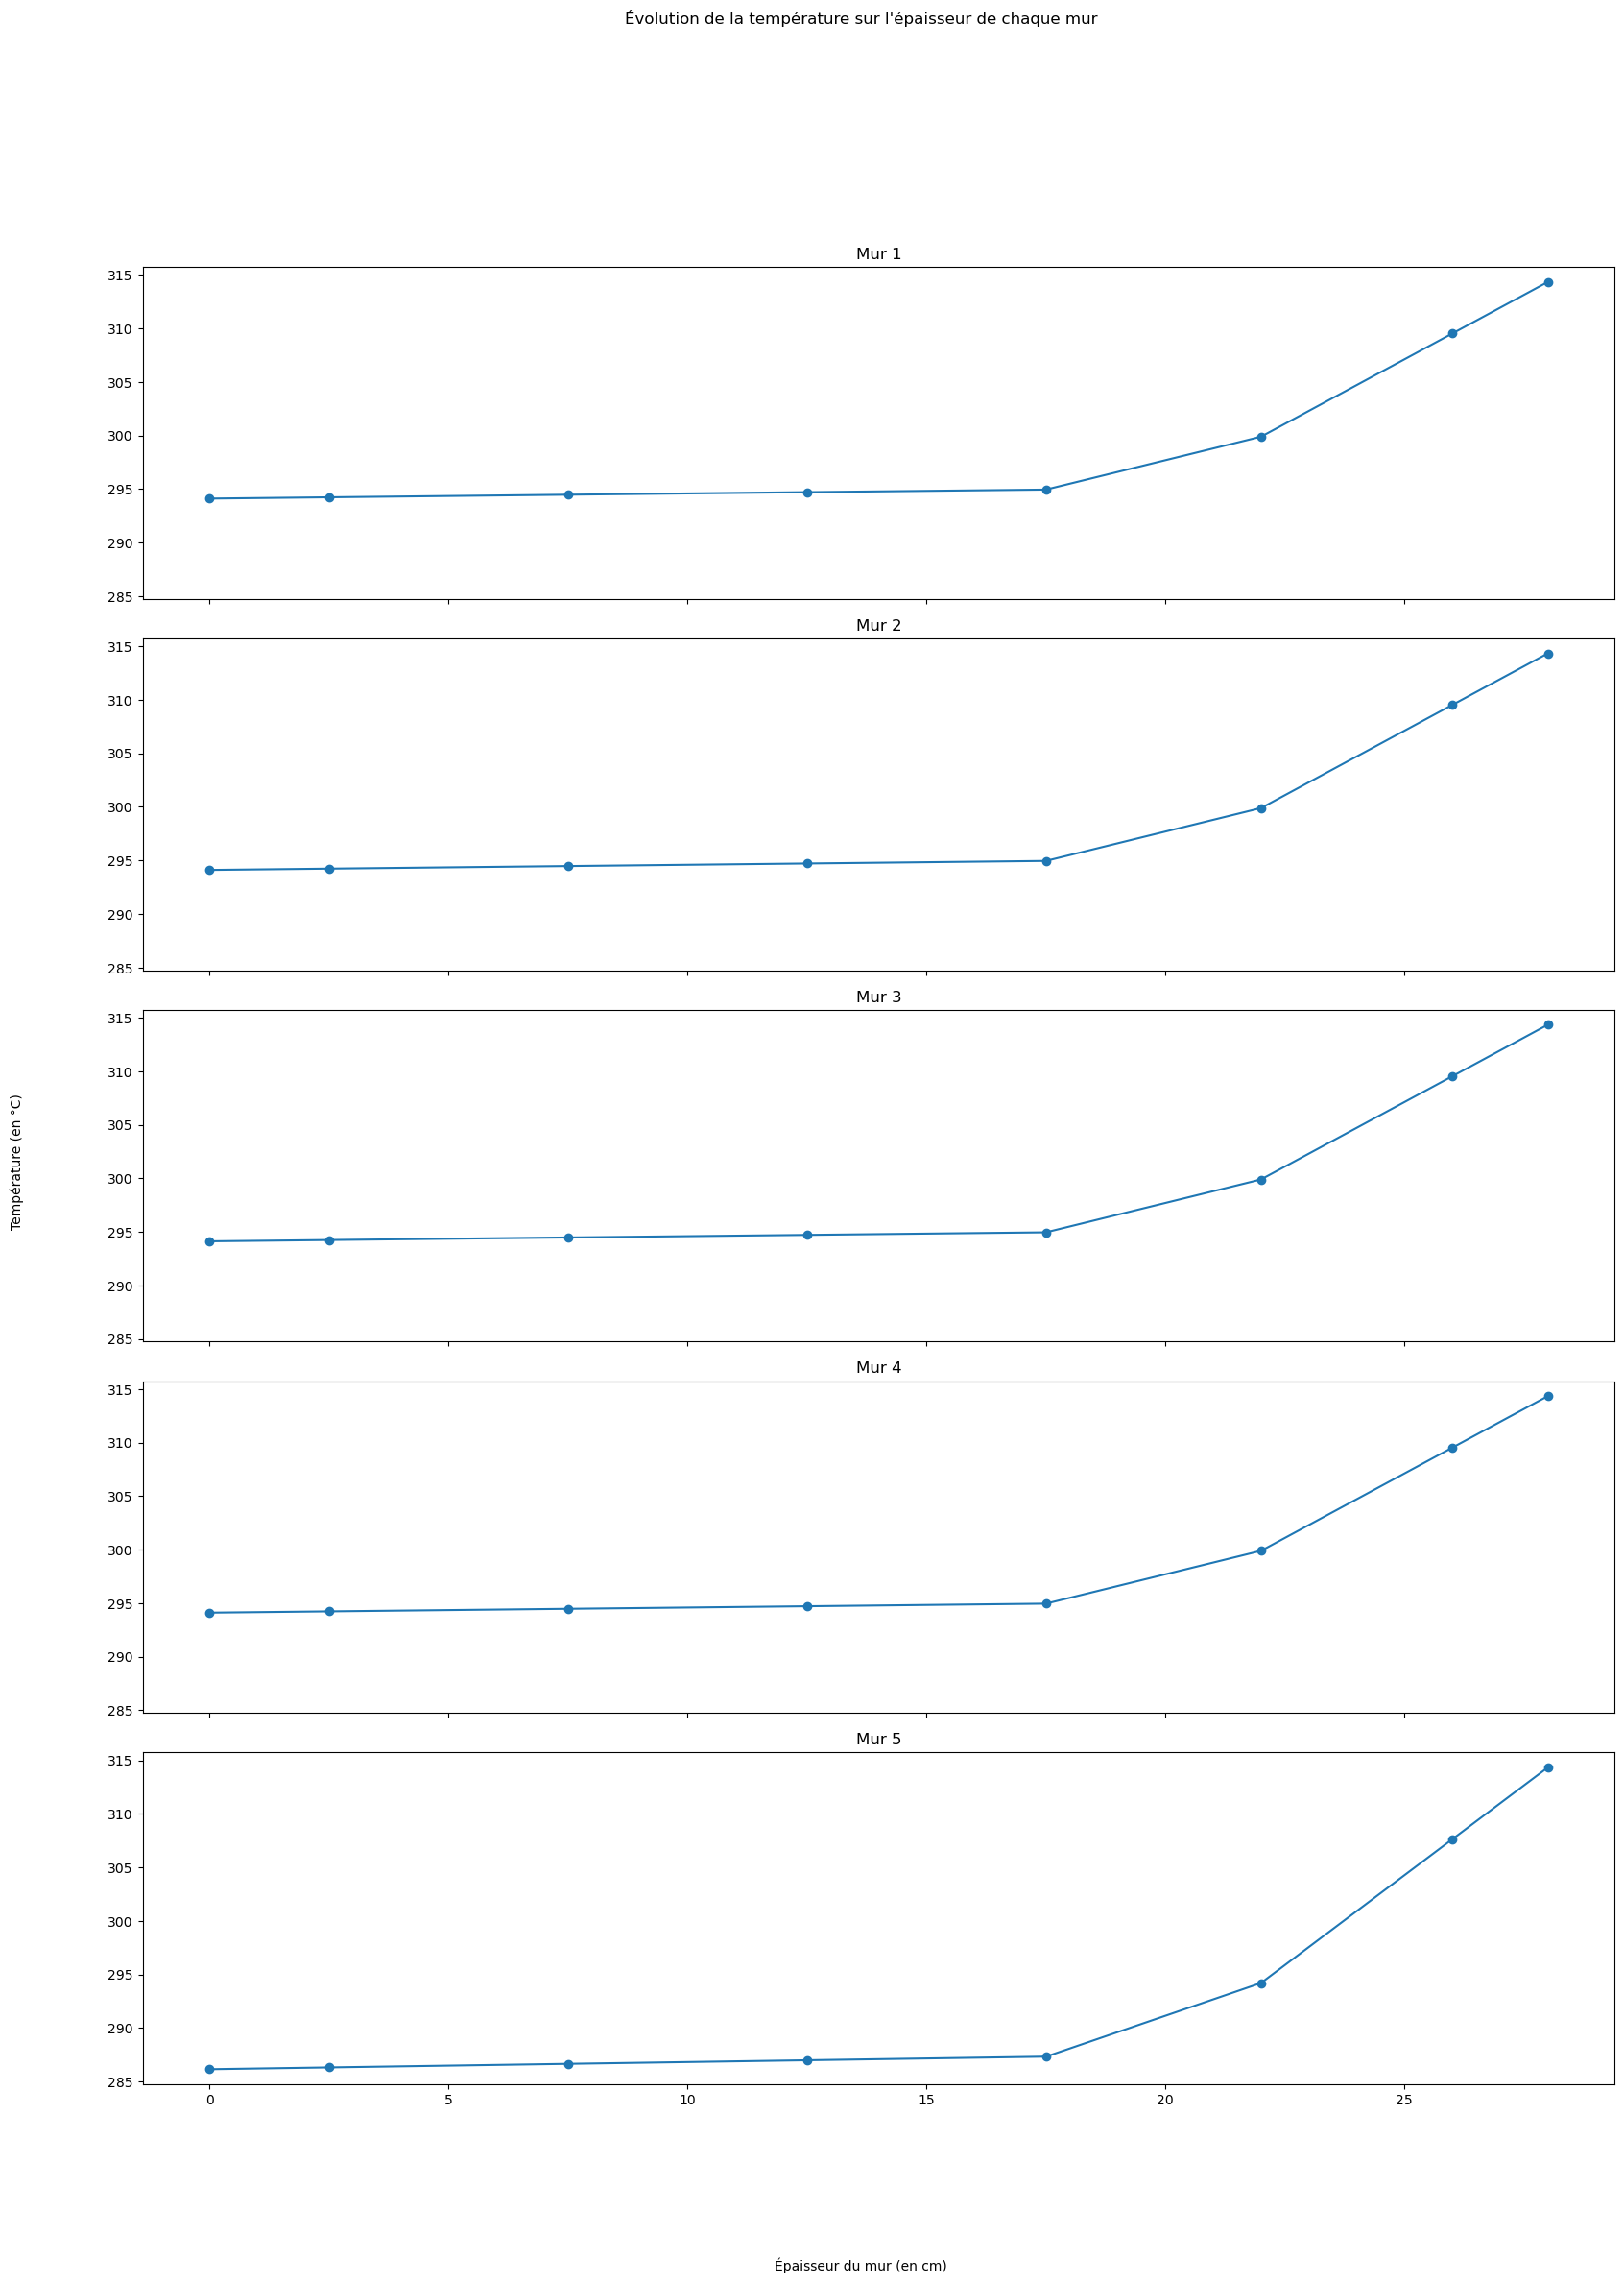

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que vous avez une liste θ représentant les températures
# Répartissez les valeurs de θ en fonction de la structure des murs
# Remplacez ces données factices par vos propres données

# Exemple de données factices

# Nombre de murs
nombre_murs = 5

# Nombre de valeurs de température par mur
valeurs_par_mur = 8

# Créer une figure avec des sous-graphiques pour chaque mur
fig, axs = plt.subplots(nombre_murs, 1, figsize=(20, 25), sharex=True, sharey=True)

x = [0,2.5,7.5,12.5,17.5,22,26,28]

# Tracer un graphique pour chaque mur
for i in range(nombre_murs):
    debut = i * valeurs_par_mur
    fin = (i + 1) * valeurs_par_mur
    mur =  θ[debut:fin]

    axs[i].plot(x,mur, label=f'Mur {i+1}', marker = 'o')
    axs[i].set_title(f'Mur {i+1}')

# Ajouter des légendes et des titres globaux
fig.suptitle("Évolution de la température sur l'épaisseur de chaque mur")
fig.text(0.5, 0.04, "Épaisseur du mur (en cm)", ha='center', va='center')
fig.text(0.06, 0.5, "Température (en °C)", ha='center', va='center', rotation='vertical')
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.show()

## Tentative temporelle

In [16]:
import csv

data = []
with open('input_data_set.csv','r',encoding = 'utf-8') as f:
    fichier = csv.reader(f,delimiter = ',')
    titres = fichier.__next__()
    for row in fichier:
        data.append([row[1],row[3],row[6]])

In [18]:
for data_h in data:
    # modification du flux absorbé par les murs béton
    
    f = np.zeros(43)

    f[32] = f_5
    f[42] = f_7
    
    f[0] = data_h[1]
    f[8] = data_h[1]
    f[16] = data_h[1]
    f[24] = data_h[1]
    
    # modification du flux absorbé par les murs béton
    
    f[40] = data_h[2]
    
    #modification de la température extérieure
    
    B[45] = data_h[0]
    B[63] = data_h[0]
    
     #calcul de la température aux différents noeuds
    U = -np.linalg.inv(C)@np.transpose(A)@G@A
    
    V = np.linalg.inv(C)@(np.transpose(A)@G@B+f)
        
    θ_prev = θ
        
    θ = np.linalg.inv(np.identity(len(θ_prev))@(np.transpose(A)@G@B+f))

LinAlgError: Singular matrix